<div style="text-align: center;">
    <h1>Bi-LSTM MODEL FOR SENTIMENT ANALYSIS</h1>
</div>


### IMPORTING LIBRARIES

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
nltk.download('punkt')
from nltk.corpus import stopwords
import string
import tensorflow as tf
import tensorflow.keras as keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gautam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/gautam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### GETTING DATA

In [3]:
df = pd.read_csv('./Twitter_Data/twitter.csv')

In [4]:
df.shape

(74681, 4)

In [5]:
df.columns=['id','category','sentiment','tweet'] # Renaming the columns 
df = df.dropna(subset=['tweet']) # droping null values
df.shape

(73995, 4)

### VISUALIZING DATA

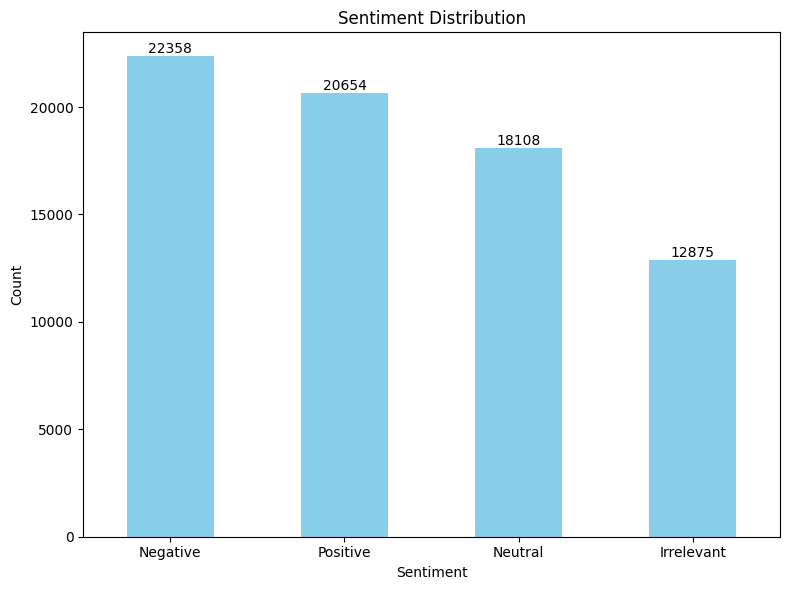

In [6]:

# Getting the value counts
sentiment_counts = df['sentiment'].value_counts()

# Plotting the value counts
plt.figure(figsize=(8, 6))
ax = sentiment_counts.plot(kind='bar', color='skyblue')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Display counts on top of each bar
for i, count in enumerate(sentiment_counts):
    ax.text(i, count + 5, str(count), ha='center', va='bottom')

plt.xticks(rotation=0)  # Rotate x-axis labels for better readability if needed
plt.tight_layout()
plt.show()

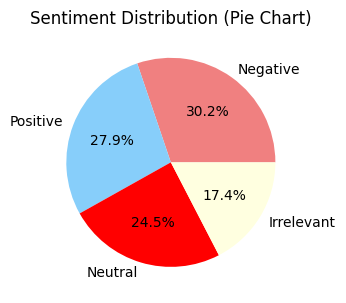

In [7]:
plt.subplot(1, 2, 2)
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue', 'red', 'lightyellow'])
plt.title('Sentiment Distribution (Pie Chart)')

plt.tight_layout()
plt.show()

### TEXT PREPROCESSING

In [8]:

# Compile regular expression pattern
REPLACE_WITH_SPACE = re.compile("(@)")

# Load English stopwords
english_stop_words = stopwords.words('english')

# Function to clean text by replacing special characters
def clean_text(text):
    cleaned_text = REPLACE_WITH_SPACE.sub(" ", text.lower())
    return cleaned_text

# Function to remove stop words from text
def remove_stop_words(text):
    words = text.split()
    filtered_words = [word for word in words if word not in english_stop_words]
    return ' '.join(filtered_words)

# Function to stem text
def stem_text(text):
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in text.split()]
    return ' '.join(stemmed_words)

# Function to clean reviews using the above functions
def clean_reviews(reviews):
    cleaned_reviews = [clean_text(review) for review in reviews]
    removed_stopwords = [remove_stop_words(review) for review in cleaned_reviews]
    stemmed_reviews = [stem_text(review) for review in removed_stopwords]
    return stemmed_reviews


In [9]:
preprocessed_reviews = clean_reviews(df['tweet']) # Preprocess the tweet column as it drives predicting sentiment

In [10]:
preprocessed_reviews[0]

'come border kill all,'

### Initializing the Tokenizer

In [11]:
# Setting the maximum number of words to consider
max_words = 8000

# Creating a tokenizer object with specific configurations
tokenizer = Tokenizer(
    num_words=max_words,  # Limiting the tokenizer to consider a maximum of 'max_words' most frequent words
    filters='"#$%&()*+-/:;<=>@[\]^_`{|}~'  # Characters to filter out from the text during tokenization
)

# Fitting the tokenizer on preprocessed_reviews to create a word index based on the text
tokenizer.fit_on_texts(preprocessed_reviews)

# Converting text sequences to sequences of integers based on the tokenizer's word index
x = tokenizer.texts_to_sequences(preprocessed_reviews)

# Padding sequences to ensure uniform length; sequences longer than maxlen are truncated, and shorter sequences are padded
x = pad_sequences(x, maxlen=300)  # Set the maximum sequence length to 300



In [12]:
len(x)

73995

In [13]:
# Initializing a Tokenizer for labels and fitting it on the 'sentiment' column in the training dataset
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(df['sentiment'])

# Converting text labels to sequences of integers using the fitted label tokenizer
y = np.array(label_tokenizer.texts_to_sequences(df['sentiment']))


In [14]:
len(y)

73995

### SPLITTING DATA TO TRAIN_TEST

In [15]:
train_x, test_x_1, train_y, test_y_1 = train_test_split(x,y, train_size = 0.8)

In [16]:
train_x.shape

(59196, 300)

In [17]:
train_y.shape

(59196, 1)

In [18]:
test_x_1.shape

(14799, 300)

In [19]:
test_y_1.shape

(14799, 1)

### INITIALIZING THE Bi-LSTM MODEL

In [20]:

# Initialize a Sequential model
model_lstm = Sequential()

# Add an Embedding layer with input dimensions, output dimensions, and input length
model_lstm.add(Embedding(input_dim=max_words, output_dim=128, input_length=300))

# Add a SpatialDropout1D layer to perform dropout on the embeddings
model_lstm.add(SpatialDropout1D(0.3))

# Add an LSTM layer with 128 units and dropout for input and recurrent connections
model_lstm.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3))

# Add a Dense layer with 128 units and ReLU activation
model_lstm.add(Dense(128, activation='relu'))

# Add a Dropout layer to prevent overfitting
model_lstm.add(Dropout(0.3))

# Add the output layer with 5 units for classification using softmax activation
model_lstm.add(Dense(5, activation='softmax'))

# Compile the model with loss function, optimizer, and evaluation metrics
model_lstm.compile(
    loss='sparse_categorical_crossentropy',  # Using sparse categorical cross-entropy loss
    optimizer='Adam',  # Using Adam optimizer for training
    metrics=['accuracy']  # Tracking accuracy metric during training
)


In [21]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 128)          1024000   
                                                                 
 spatial_dropout1d (Spatial  (None, 300, 128)          0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                        

### TRAINING THE MODEL

In [22]:
history = model_lstm.fit(
    train_x,
    train_y,
    validation_data=(test_x_1,test_y_1) ,
    epochs = 10,
    batch_size = 512
)

Epoch 1/10
116/116 [==============================] - 268s 2s/step - loss: 1.2572 - accuracy: 0.4267 - val_loss: 0.9748 - val_accuracy: 0.6029
Epoch 2/10
116/116 [==============================] - 271s 2s/step - loss: 0.8505 - accuracy: 0.6663 - val_loss: 0.7605 - val_accuracy: 0.7017
Epoch 3/10
116/116 [==============================] - 256s 2s/step - loss: 0.6735 - accuracy: 0.7424 - val_loss: 0.6923 - val_accuracy: 0.7259
Epoch 4/10
116/116 [==============================] - 260s 2s/step - loss: 0.5868 - accuracy: 0.7771 - val_loss: 0.6517 - val_accuracy: 0.7491
Epoch 5/10
116/116 [==============================] - 275s 2s/step - loss: 0.5300 - accuracy: 0.7993 - val_loss: 0.6157 - val_accuracy: 0.7668
Epoch 6/10
116/116 [==============================] - 2480s 22s/step - loss: 0.4809 - accuracy: 0.8155 - val_loss: 0.5814 - val_accuracy: 0.7823
Epoch 7/10
116/116 [==============================] - 271s 2s/step - loss: 0.4374 - accuracy: 0.8338 - val_loss: 0.5737 - val_accuracy: 0.78

### Testing Acurracy on test Data

In [23]:
accr = model_lstm.evaluate(test_x_1,test_y_1)


463/463 [==============================] - 2933s 6s/step - loss: 0.5686 - accuracy: 0.8033


In [24]:
print(f'Accuracy on testing data is {accr[1]*100:.2f}% with loss as {accr[0]*100:.2f}%.')

Accuracy on testing data is 80.33% with loss as 56.86%.


### PLOTTING HOW MODEL EVOLVED OVER EPOCHS

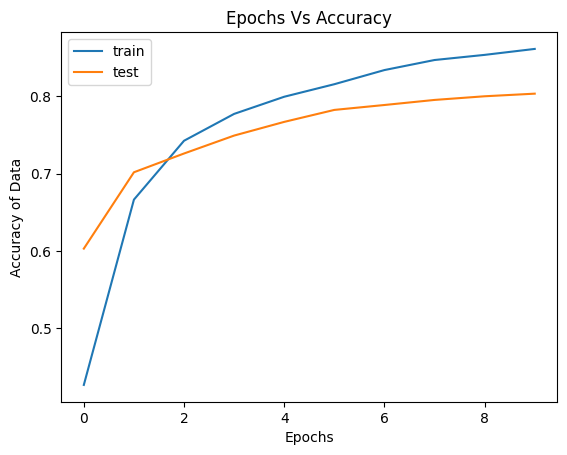

In [25]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='train')         # Plotting training accuracy values
plt.plot(history.history['val_accuracy'], label='test')      # Plotting testing/validation accuracy values
plt.xlabel('Epochs')                                        # Labeling the x-axis as 'Epochs'
plt.ylabel('Accuracy of Data')                              # Labeling the y-axis as 'Accuracy of Data'
plt.title('Epochs Vs Accuracy')                              # Setting the title of the plot
plt.legend()                                                 # Displaying the legend for train and test lines
plt.show()                                                   


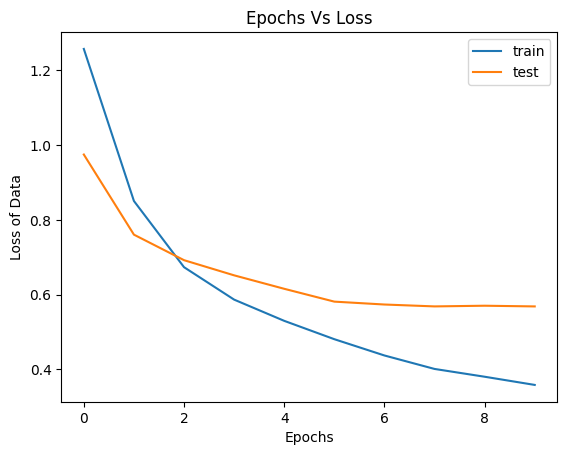

In [26]:
plt.plot(history.history['loss'], label='train')         # Plotting training loss values
plt.plot(history.history['val_loss'], label='test')      # Plotting testing/validation loss values
plt.xlabel('Epochs')                                     # Labeling the x-axis as 'Epochs'
plt.ylabel('Loss of Data')                               # Labeling the y-axis as 'Loss of Data'
plt.title('Epochs Vs Loss')                              # Setting the title of the plot
plt.legend()                                             # Displaying the legend for train and test lines
plt.show()  